# 👋 About Me
# Hi! I am Priyansh!

[![GitHub](https://img.icons8.com/?size=50&id=12599&format=png)](https://github.com/PRIYANSH-2004)
[![LinkedIn](https://img.icons8.com/?size=50&id=13930&format=png)](https://www.linkedin.com/in/priyansh-singh-8b70b7227/)
[![Portfolio](https://img.icons8.com/?size=50&id=LoyAjcvVKv1K&format=png)](https://portfolio-zeta-dun-43.vercel.app/)




# Electricity Demand Forecasting for Kansai Electric Power
## Project Overview

This project implements an advanced machine learning solution for forecasting electricity demand within the Kansai Electric Power jurisdiction in Japan. The forecasting model combines sophisticated time series analysis, weather data integration, and ensemble learning techniques to predict hourly electricity consumption patterns throughout 2023.

---


---

## Technical Approach

The solution employs a comprehensive methodology including:

### 1. Data Integration & Preprocessing
- Historical electricity demand data from Kansai Electric Power
- Weather data from multiple locations within the service area
- Japanese holiday calendar integration
- Temporal feature engineering

### 2. Exploratory Data Analysis (EDA)
- Temporal pattern analysis
- Seasonality decomposition


### 3. Feature Engineering
- Rolling statistics
- Lag features
- Holiday indicators

### 4. Model Architecture
- XGBoost: For capturing complex non-linear relationships
- LightGBM: For handling large-scale data with high efficiency
- Ensemble weighting: For optimal model combination

---

## MLFlow Experiment Tracking
### Following MLOps Practices is necsessary. Right now mlflow tracking is based on ngrok tunneling with localhost.


---

# Importing Libraries

In [21]:
%%capture
!pip install jpholiday mlflow ultralytics roboflow pyyaml

In [22]:
import os
import mlflow
import mlflow.pytorch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from xgboost import XGBRegressor, plot_importance
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
import jpholiday
import lightgbm as lgb
import xgboost as xgb
from xgboost import XGBRegressor, plot_importance
from sklearn.model_selection import GridSearchCV

# Loading data

In [23]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [24]:
mlflow.set_tracking_uri("file:" + os.path.join(os.getcwd(), "mlruns"))

# Set up MLflow experiment
mlflow.set_experiment("exp1")

<Experiment: artifact_location='file:///content/mlruns/863125301970583041', creation_time=1740053834870, experiment_id='863125301970583041', last_update_time=1740053834870, lifecycle_stage='active', name='exp1', tags={}>

all cities files loading

In [25]:
hikone="/content/drive/MyDrive/STAR AI/Weather/hikone.csv"
kobe="/content/drive/MyDrive/STAR AI/Weather/kobe.csv"
kyoto="/content/drive/MyDrive/STAR AI/Weather/kyoto.csv"
osaka="/content/drive/MyDrive/STAR AI/Weather/osaka.csv"
shionomisaki="/content/drive/MyDrive/STAR AI/Weather/shionomisaki.csv"
toyooka="/content/drive/MyDrive/STAR AI/Weather/toyooka.csv"
wakayama="/content/drive/MyDrive/STAR AI/Weather/wakayama.csv"
nara="/content/drive/MyDrive/STAR AI/Weather/nara.csv"

city_files = [hikone, kobe, kyoto, osaka, shionomisaki, toyooka, wakayama]

In [26]:
def translate_wind_direction_to_degrees(direction_chinese):
    """Translates Chinese wind direction to degrees (numerical representation)."""
    translations = {
        '南': 180,  # South
        '南南西': 202.5,  # South-Southwest
        '南南東': 157.5,  # South-Southeast
        '西': 270,  # West
        '北西': 315,  # Northwest
        '南西': 225,  # Southwest
        '西北西': 292.5,  # West-Northwest
        '西南西': 247.5,  # West-Southwest
        '南東': 135,  # Southeast
        '北北西': 337.5,  # North-Northwest
        '北東': 45,  # Northeast
        '東南東': 112.5,  # East-Southeast
        '東': 90,  # East
        '北': 0,  # North
        '北北東': 22.5,  # North-Northeast
        '東北東': 67.5,  # East-Northeast
        '静穏': 0,  # Calm (can be represented as 0 degrees)
        '×': -1  # Unknown (use -1 to indicate unknown)
    }
    return translations.get(direction_chinese, -1)

In [27]:

def process_wind_data(csv_file_path):
    try:
        df = pd.read_csv(csv_file_path, parse_dates=['datetime'])
    except FileNotFoundError:
        print(f"Error: File '{csv_file}' not found.")
        return None

    df['wind_direction'] = df['wind_direction'].apply(translate_wind_direction_to_degrees)
    return df


city_dfs = [process_wind_data(file) for file in city_files]



### city weights on the basis of diffrent factors such as population, industries, urban, rural etc.

| City          | Normalized Weight | Key Features for AI Model (Example Values) |
|--------------|------------------|--------------------------------------------|
| Osaka        | 1.00             | Industrial activity (0.95), Population density (0.90), GDP (0.98) |
| Kobe         | 0.85             | Port activity (0.80), Manufacturing (0.75), Tourism (0.60) |
| Kyoto        | 0.75             | Tech industries (0.70), Tourism (0.85), Residential density (0.65) |
| Wakayama     | 0.55             | Heavy industry (0.50), Port activity (0.40), Tourism (0.30) |
| Hikone       | 0.35             | Light industry (0.25), Tourism (0.20), Population density (0.15) |
| Toyooka      | 0.25             | Agriculture (0.60), Rural population (0.80), Eco-tourism (0.10) |
| Shionomisaki | 0.10             | Fishing (0.70), Rural population (0.90), Tourism (0.05) |
| Nara | 0.45             | Tourism (0.75), Agriculture (0.30), Residential density (0.40) |


In [28]:
city_files = [hikone, kobe, kyoto, osaka, shionomisaki, toyooka, wakayama, nara]
city_weights = [0.35, 0.85, 0.75, 1.0, 0.1, 0.25, 0.55, 0.45]

# city_weights = [1, 1, 1, 1, 1, 1, 1]

# Merge all city DataFrames
merged_df = city_dfs[0]

for df in city_dfs[1:]:
    merged_df = merged_df.merge(df, on="datetime", suffixes=('', '_other'), how='inner')



# Assign weights correctly
for city, weight in zip(city_files, city_weights):  # Iterate over both lists
    for feature in ["temperature", "dew_point_temperature", "humidity", "wind_speed"]:
        col_name = f"{feature}_{city}"  # Construct column name
        if col_name in merged_df.columns:
            merged_df[col_name] *= weight  # Apply weight correctly

#

### Aggregation Strategy for Each Feature

| Feature                 | Aggregation Method               | Reason |
|-------------------------|---------------------------------|--------|
| **precipitation**       | Mean                             |  precipitation in a region affects energy demand (e.g., rain increases heating demand). |
| **temperature**         | Mean | Temperature influences heating/cooling demand. Weighting by population ensures bigger cities impact more. |
| **dew_point_temperature** | Mean                            | Reflects overall atmospheric moisture across cities. |
| **humidity**            | Mean                            | Humidity affects HVAC (Heating, Ventilation, and Air Conditioning) demand. |
| **wind_speed**          | Mean                            | Wind speed affects cooling needs and renewable energy sources like wind power. |
| **wind_direction**      | Mode (Most frequent value)      | Wind patterns are generally consistent over regions and influence energy generation. |
| **snowfall**            | Mean                             | Higher snowfall increases heating demand and affects energy infrastructure. |


In [29]:
aggregations = {
    "precipitation":lambda x: np.sum(x) / sum(city_weights),
    "temperature": lambda x: np.sum(x) / sum(city_weights),
    "dew_point_temperature": lambda x: np.sum(x) / sum(city_weights),
    "humidity": lambda x: np.sum(x) / sum(city_weights),
    "wind_speed": lambda x: np.sum(x) / sum(city_weights),
    "snowfall": lambda x: np.sum(x) / sum(city_weights),
}


def weighted_mode(series):
    valid_data = series
    if valid_data.empty:
        return np.nan
    unique_values, counts = np.unique(valid_data, return_counts=True)
    return unique_values[np.argmax(counts)]

# Apply weighted mode for wind direction
aggregations["wind_direction"] = lambda x: weighted_mode(x)

# Group by datetime to compute final aggregated features
final_city_features = merged_df.groupby("datetime").agg(aggregations).reset_index()


In [30]:
# print(merged_df.head())
# print(merged_df.describe())

In [31]:
# final_city_features.to_csv('final_city_features_weighted.csv', index=False)
print(final_city_features.describe())
print(final_city_features.shape)

                  datetime  precipitation   temperature  \
count                26280   26280.000000  26280.000000   
mean   2022-07-02 11:30:00       0.041339      3.707471   
min    2021-01-01 00:00:00       0.000000     -0.976744   
25%    2021-10-01 17:45:00       0.000000      1.906977   
50%    2022-07-02 11:30:00       0.000000      3.674419   
75%    2023-04-02 05:15:00       0.000000      5.558140   
max    2023-12-31 23:00:00       8.720930      8.465116   
std                    NaN       0.226310      2.101330   

       dew_point_temperature      humidity    wind_speed      snowfall  \
count           26280.000000  26280.000000  26280.000000  26280.000000   
mean                2.638567     17.545432      0.670000      0.002434   
min                -4.046512      0.000000      0.000000      0.000000   
25%                 0.837209     15.348837      0.325581      0.000000   
50%                 2.558140     17.906977      0.511628      0.000000   
75%                 4.58

## splititng date and time

In [32]:

final_city_features["datetime"] = pd.to_datetime(final_city_features["datetime"])


final_city_features['hour'] = final_city_features['datetime'].dt.hour
final_city_features['day_of_week'] = final_city_features['datetime'].dt.dayofweek
final_city_features['month'] = final_city_features['datetime'].dt.month
final_city_features['is_holiday'] = final_city_features['datetime'].apply(lambda x: jpholiday.is_holiday(x))
final_city_features['is_weekend'] = final_city_features['day_of_week'].isin([5, 6]).astype(int)


# final_city_features.drop(columns=["datetime"], inplace=True)


print(final_city_features.head())



             datetime  precipitation  temperature  dew_point_temperature  \
0 2021-01-01 00:00:00            0.0     0.069767              -1.139535   
1 2021-01-01 01:00:00            0.0     0.069767              -1.093023   
2 2021-01-01 02:00:00            0.0     0.000000              -1.116279   
3 2021-01-01 03:00:00            0.0    -0.186047              -1.093023   
4 2021-01-01 04:00:00            0.0     0.046512              -0.930233   

    humidity  wind_speed  snowfall  wind_direction  hour  day_of_week  month  \
0  15.813953    0.883721       0.0           180.0     0            4      1   
1  16.046512    0.860465       0.0           202.5     1            4      1   
2  16.279070    0.813953       0.0           202.5     2            4      1   
3  17.441860    0.534884       0.0           157.5     3            4      1   
4  16.976744    0.581395       0.0           202.5     4            4      1   

   is_holiday  is_weekend  
0        True           0  
1     

Scaling all features using MinMax Scaling between 0-1

In [33]:
scaler = MinMaxScaler()
numerical_columns = merged_df.columns.difference(['datetime'])

merged_df[numerical_columns] = scaler.fit_transform(merged_df[numerical_columns])
print(merged_df.head())

             datetime  precipitation  temperature  dew_point_temperature  \
0 2021-01-01 00:00:00            0.0     0.110837               0.281532   
1 2021-01-01 01:00:00            0.0     0.110837               0.286036   
2 2021-01-01 02:00:00            0.0     0.103448               0.283784   
3 2021-01-01 03:00:00            0.0     0.083744               0.286036   
4 2021-01-01 04:00:00            0.0     0.108374               0.301802   

   humidity  wind_speed  wind_direction  snowfall  precipitation_other  \
0      0.68    0.240506        0.534712       0.0                  0.0   
1      0.69    0.234177        0.601182       0.0                  0.0   
2      0.70    0.221519        0.601182       0.0                  0.0   
3      0.75    0.145570        0.468242       0.0                  0.0   
4      0.73    0.158228        0.601182       0.0                  0.0   

   temperature_other  ...  wind_speed_other  wind_direction_other  \
0           0.125641  ...    

In [34]:

scaler = MinMaxScaler()
numerical_columns = final_city_features.columns.difference(['datetime'])

final_city_features[numerical_columns] = scaler.fit_transform(final_city_features[numerical_columns])
print(final_city_features.head())

             datetime  precipitation  temperature  dew_point_temperature  \
0 2021-01-01 00:00:00            0.0     0.110837               0.281532   
1 2021-01-01 01:00:00            0.0     0.110837               0.286036   
2 2021-01-01 02:00:00            0.0     0.103448               0.283784   
3 2021-01-01 03:00:00            0.0     0.083744               0.286036   
4 2021-01-01 04:00:00            0.0     0.108374               0.301802   

   humidity  wind_speed  snowfall  wind_direction      hour  day_of_week  \
0      0.68    0.240506       0.0        0.534712  0.000000     0.666667   
1      0.69    0.234177       0.0        0.601182  0.043478     0.666667   
2      0.70    0.221519       0.0        0.601182  0.086957     0.666667   
3      0.75    0.145570       0.0        0.468242  0.130435     0.666667   
4      0.73    0.158228       0.0        0.601182  0.173913     0.666667   

   month  is_holiday  is_weekend  
0    0.0         1.0         0.0  
1    0.0        

In [35]:
# Load data
df = pd.read_csv('/content/drive/MyDrive/STAR AI/electricity_demand/demand.csv', parse_dates=['datetime'])
df.rename(columns={df.columns[1]: 'demand'}, inplace=True)  # Rename column for clarity
df = df.iloc[:, :-1]
# Check data
print(df.head())
print(df.isnull().sum())  # Check for missing values
df.describe()

             datetime  demand
0 2021-01-01 00:00:00    1571
1 2021-01-01 01:00:00    1492
2 2021-01-01 02:00:00    1453
3 2021-01-01 03:00:00    1412
4 2021-01-01 04:00:00    1358
datetime    0
demand      0
dtype: int64


,datetime,demand
count,26280,26280.000000
mean,2022-07-02 11:30:00,1616.426180
min,2021-01-01 00:00:00,955.000000
25%,2021-10-01 17:45:00,1359.000000
50%,2022-07-02 11:30:00,1572.000000
75%,2023-04-02 05:15:00,1816.000000
max,2023-12-31 23:00:00,2827.000000
std,NaN,328.186899


Merging 2 datasets


In [36]:
final_dataset = pd.merge(df, final_city_features, on='datetime', how='outer')
print(final_dataset.head())
print('*****************************')
print(final_dataset.describe())
print('*****************************')
print(final_dataset.isna().sum())
print('*****************************')
print(final_dataset.columns)
# no null except unckwon in wind_direction
# final_dataset.to_csv('final_dataset.csv', index=False)

             datetime  demand  precipitation  temperature  \
0 2021-01-01 00:00:00    1571            0.0     0.110837   
1 2021-01-01 01:00:00    1492            0.0     0.110837   
2 2021-01-01 02:00:00    1453            0.0     0.103448   
3 2021-01-01 03:00:00    1412            0.0     0.083744   
4 2021-01-01 04:00:00    1358            0.0     0.108374   

   dew_point_temperature  humidity  wind_speed  snowfall  wind_direction  \
0               0.281532      0.68    0.240506       0.0        0.534712   
1               0.286036      0.69    0.234177       0.0        0.601182   
2               0.283784      0.70    0.221519       0.0        0.601182   
3               0.286036      0.75    0.145570       0.0        0.468242   
4               0.301802      0.73    0.158228       0.0        0.601182   

       hour  day_of_week  month  is_holiday  is_weekend  
0  0.000000     0.666667    0.0         1.0         0.0  
1  0.043478     0.666667    0.0         1.0         0.0  
2 

Plotting

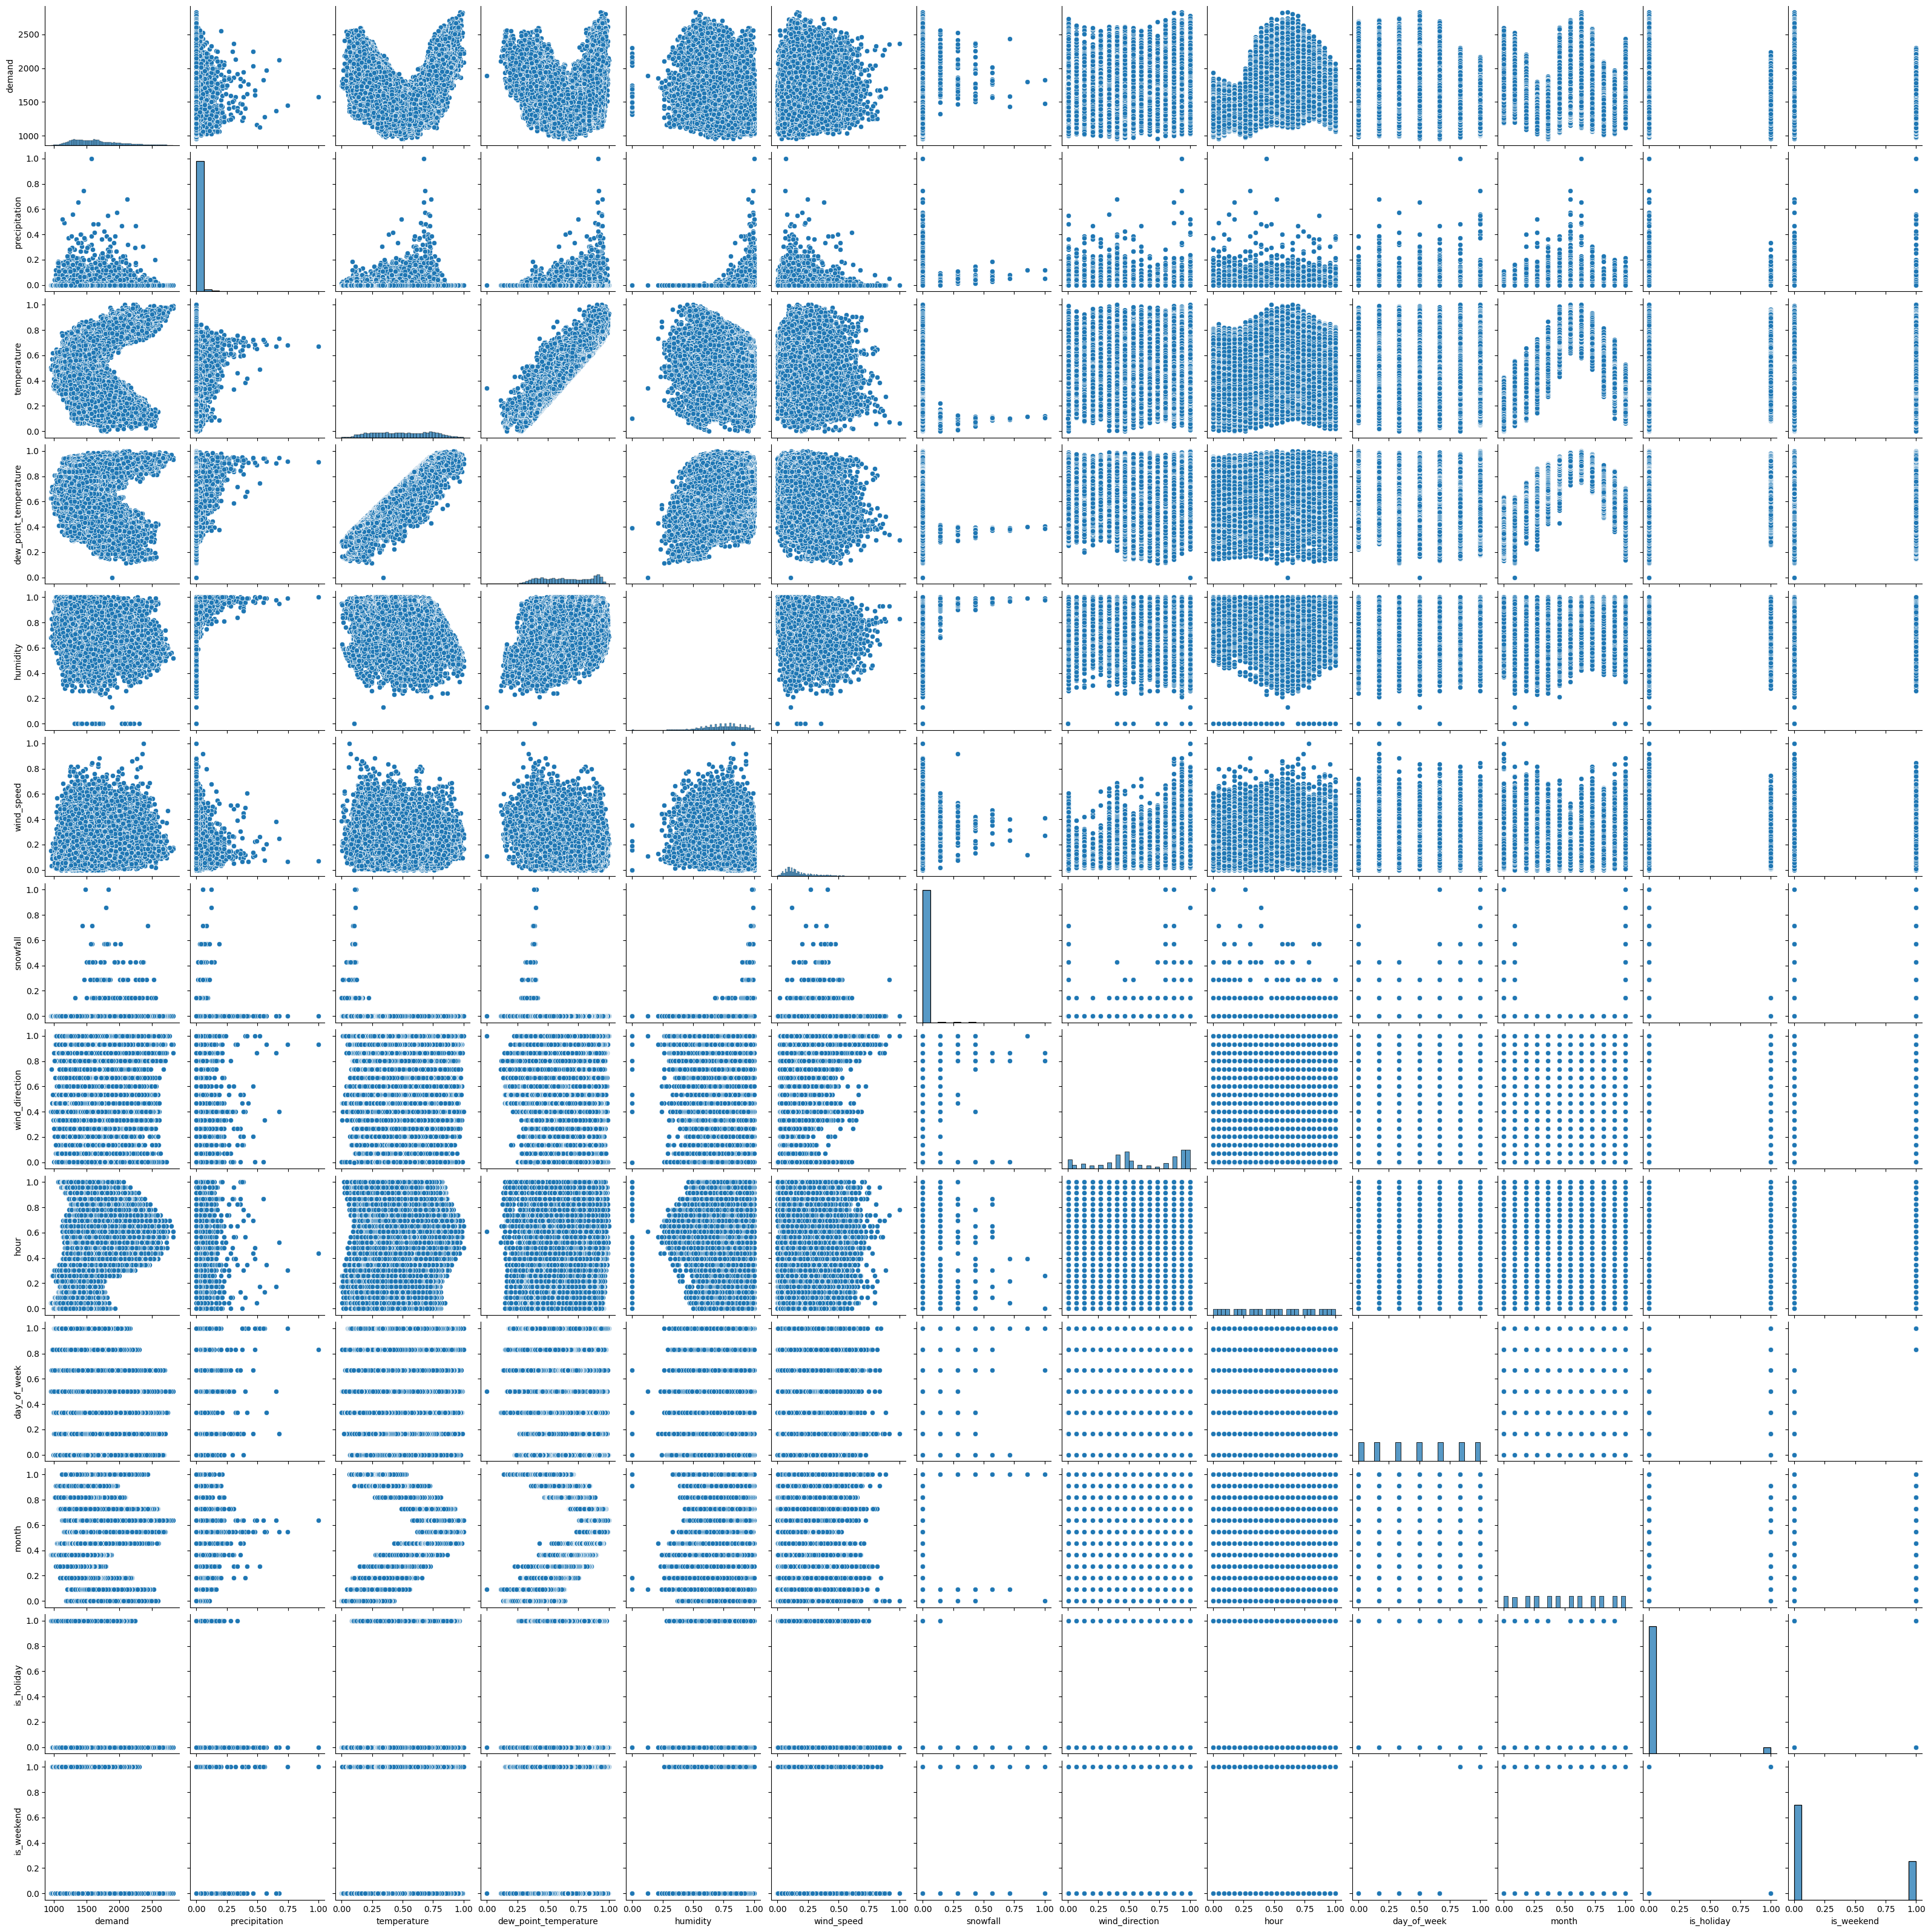

In [37]:
sns.pairplot(final_dataset[['datetime', 'demand', 'precipitation', 'temperature',
       'dew_point_temperature', 'humidity', 'wind_speed', 'snowfall',
       'wind_direction', 'hour', 'day_of_week', 'month', 'is_holiday',
       'is_weekend']])
plt.show()

Heatmap

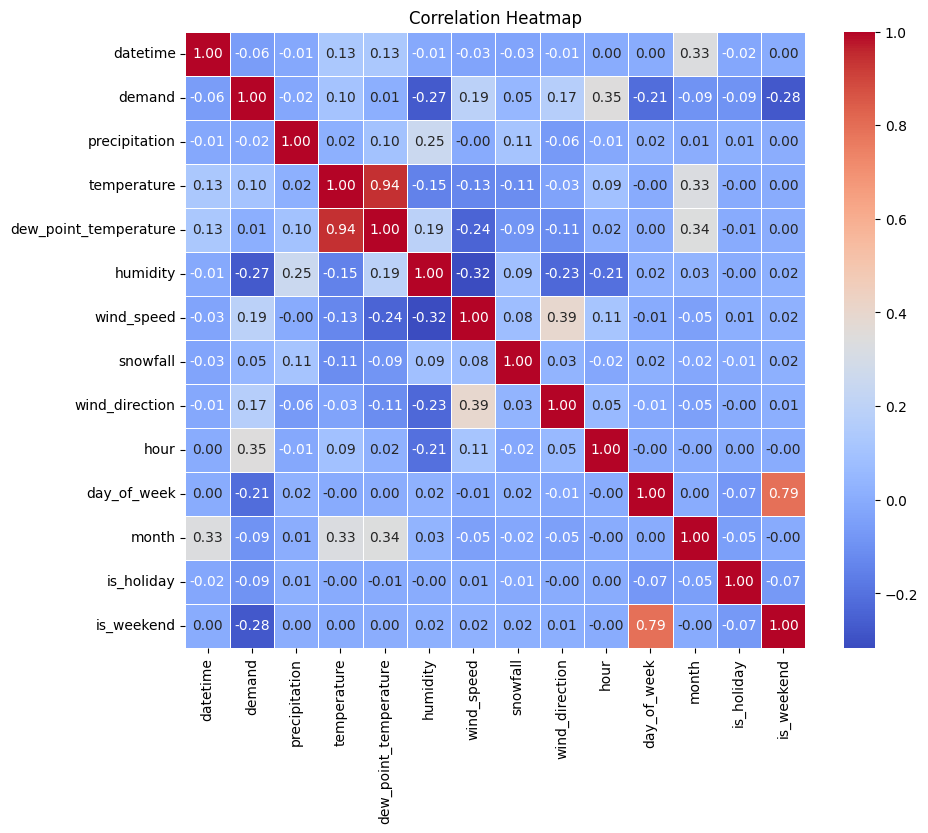

In [38]:
# Calculate correlation matrix
correlation_matrix = final_dataset[['datetime', 'demand', 'precipitation', 'temperature',
       'dew_point_temperature', 'humidity', 'wind_speed', 'snowfall',
       'wind_direction', 'hour', 'day_of_week', 'month', 'is_holiday',
       'is_weekend']].corr()

# Create a heatmap of the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

hikone
kobe
kyoto

osaka
shionomisaki
toyooka
wakayama

# Feature Engineering

In [39]:
print(final_dataset.head(10))

             datetime  demand  precipitation  temperature  \
0 2021-01-01 00:00:00    1571            0.0     0.110837   
1 2021-01-01 01:00:00    1492            0.0     0.110837   
2 2021-01-01 02:00:00    1453            0.0     0.103448   
3 2021-01-01 03:00:00    1412            0.0     0.083744   
4 2021-01-01 04:00:00    1358            0.0     0.108374   
5 2021-01-01 05:00:00    1298            0.0     0.096059   
6 2021-01-01 06:00:00    1305            0.0     0.086207   
7 2021-01-01 07:00:00    1401            0.0     0.100985   
8 2021-01-01 08:00:00    1535            0.0     0.105911   
9 2021-01-01 09:00:00    1555            0.0     0.130542   

   dew_point_temperature  humidity  wind_speed  snowfall  wind_direction  \
0               0.281532      0.68    0.240506       0.0        0.534712   
1               0.286036      0.69    0.234177       0.0        0.601182   
2               0.283784      0.70    0.221519       0.0        0.601182   
3               0.286036

Train test split

In [41]:
from sklearn.model_selection import train_test_split
# with mlflow.start_run(run_name="run2"):
X = final_dataset.drop(columns=["datetime", "demand"])
y = final_dataset["demand"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=False)

# Print dataset shapes
print("Train set size:", X_train.shape, y_train.shape)
print("Test set size:", X_test.shape, y_test.shape)

Train set size: (18396, 12) (18396,)
Test set size: (7884, 12) (7884,)


In [42]:
print(X_train.head())
print(y_train.head())
print('**********************')
print(X_test.head())
print(y_test.head())

   precipitation  temperature  dew_point_temperature  humidity  wind_speed  \
0            0.0     0.110837               0.281532      0.68    0.240506   
1            0.0     0.110837               0.286036      0.69    0.234177   
2            0.0     0.103448               0.283784      0.70    0.221519   
3            0.0     0.083744               0.286036      0.75    0.145570   
4            0.0     0.108374               0.301802      0.73    0.158228   

   snowfall  wind_direction      hour  day_of_week  month  is_holiday  \
0       0.0        0.534712  0.000000     0.666667    0.0         1.0   
1       0.0        0.601182  0.043478     0.666667    0.0         1.0   
2       0.0        0.601182  0.086957     0.666667    0.0         1.0   
3       0.0        0.468242  0.130435     0.666667    0.0         1.0   
4       0.0        0.601182  0.173913     0.666667    0.0         1.0   

   is_weekend  
0         0.0  
1         0.0  
2         0.0  
3         0.0  
4         0.

# Model Training


Optimizer ->adam (Momentum + Root Mean Square Propagation)

## Model 1 : XGBOOST

In [43]:
xgb_model = xgb.XGBRegressor(tree_method='hist')

xgb_model.fit(
    X_train,
    y_train,
    eval_set=[(X_test, y_test)],
    verbose=True
)

[0]	validation_0-rmse:251.73732
[1]	validation_0-rmse:198.01930
[2]	validation_0-rmse:163.08348
[3]	validation_0-rmse:140.00649
[4]	validation_0-rmse:124.97767
[5]	validation_0-rmse:115.64558
[6]	validation_0-rmse:110.04029
[7]	validation_0-rmse:106.22396
[8]	validation_0-rmse:103.44063
[9]	validation_0-rmse:102.01036
[10]	validation_0-rmse:101.21544
[11]	validation_0-rmse:100.94866
[12]	validation_0-rmse:100.47150
[13]	validation_0-rmse:100.15261
[14]	validation_0-rmse:99.81915
[15]	validation_0-rmse:99.59088
[16]	validation_0-rmse:99.84938
[17]	validation_0-rmse:99.84352
[18]	validation_0-rmse:99.60221
[19]	validation_0-rmse:99.45204
[20]	validation_0-rmse:99.57487
[21]	validation_0-rmse:99.59155
[22]	validation_0-rmse:99.51558
[23]	validation_0-rmse:99.23320
[24]	validation_0-rmse:99.14490
[25]	validation_0-rmse:99.15262
[26]	validation_0-rmse:99.02322
[27]	validation_0-rmse:98.97082
[28]	validation_0-rmse:98.83020
[29]	validation_0-rmse:98.90537
[30]	validation_0-rmse:98.96133
[31]

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [44]:
# Evaluate the model on the test set
y_pred = xgb_model.predict(X_train)
# y_test = y_test.values.ravel()
mse = mean_squared_error(y_train, y_pred)
mae = mean_absolute_error(y_train, y_pred)
r2 = r2_score(y_train,y_pred)
# import numpy as np

def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape = mean_absolute_percentage_error(y_train, y_pred)
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
print("Mean squared error on test set: ", mse)
print("Mean absolute error on test set: ", mae)
print("r2 score ",r2)

Mean Absolute Percentage Error (MAPE): 2.15%
Mean squared error on test set:  2512.23193359375
Mean absolute error on test set:  35.308135986328125
r2 score  0.9764739871025085


In [45]:
# Evaluate the model on the test set
y_pred = xgb_model.predict(X_test)
# y_test = y_test.values.ravel()
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test,y_pred)
# import numpy as np

def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape = mean_absolute_percentage_error(y_test, y_pred)
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
print("Mean squared error on test set: ", mse)
print("Mean absolute error on test set: ", mae)
print("r2 score ",r2)

Mean Absolute Percentage Error (MAPE): 4.58%
Mean squared error on test set:  9961.7001953125
Mean absolute error on test set:  70.5289535522461
r2 score  0.9065802693367004


In [46]:
# import joblib

# # Save the trained model
# joblib.dump(xgb_model, "xgb_model_summarized.pkl")
# print("Model saved successfully!")

## Model 2: LightGBM

In [47]:


lgb_model = lgb.LGBMRegressor(
    boosting_type="gbdt",
    learning_rate=0.05,
    num_leaves=31,
    max_depth=-1,
    n_estimators=1000,
    verbosity=-1
)

# Train the model
lgb_model.fit(X_train, y_train, eval_set=[(X_test, y_test)])

# Make predictions
y_pred = lgb_model.predict(X_test)

# Evaluate performance
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"🔹 Mean Squared Error (MSE): {mse:.4f}")
print(f"🔹 Mean Absolute Error (MAE): {mae:.4f}")
print(f"🔹 Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"🔹 R² Score: {r2:.4f}")

🔹 Mean Squared Error (MSE): 9318.3160
🔹 Mean Absolute Error (MAE): 68.4719
🔹 Root Mean Squared Error (RMSE): 96.5314
🔹 R² Score: 0.9126


In [48]:
# import joblib

# # Save the trained model
# joblib.dump(lgb_model, "lgb_model_summarized.pkl")
# print("Model saved successfully!")

## Ensembling Xgboost +  LGB

In [49]:
y_pred_xgb = xgb_model.predict(X_test)
y_pred_lgb = lgb_model.predict(X_test)

# Weighted average ensemble
w_xgb = 0.5  # Assign appropriate weights based on model performance
w_lgb = 0.5
y_pred_ensemble = (w_xgb * y_pred_xgb) + (w_lgb * y_pred_lgb)

# Evaluate performance
mse = mean_squared_error(y_test, y_pred_ensemble)
mae = mean_absolute_error(y_test, y_pred_ensemble)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred_ensemble)

print(f"🔹 Mean Squared Error (MSE): {mse:.4f}")
print(f"🔹 Mean Absolute Error (MAE): {mae:.4f}")
print(f"🔹 Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"🔹 R² Score: {r2:.4f}")

🔹 Mean Squared Error (MSE): 9371.8626
🔹 Mean Absolute Error (MAE): 68.4801
🔹 Root Mean Squared Error (RMSE): 96.8084
🔹 R² Score: 0.9121


In [50]:
!pip install mlflow seaborn

# MLflow Experiment Tracking

### Following MLOps Practices is necsessary. Right now mlflow tracking is based on ngrok tunneling with localhost.

In [52]:
import mlflow
import mlflow.xgboost
import mlflow.lightgbm
import matplotlib.pyplot as plt
import seaborn as sns

with mlflow.start_run(run_name="demand_forecast_ensemble") as run:

    mlflow.log_params({
        "xgb_tree_method": xgb_model.get_params()["tree_method"],
        "ensemble_weight_xgb": w_xgb,
        "ensemble_weight_lgb": w_lgb
    })

    # Log metrics for individual models and ensemble
    mlflow.log_metrics({
        "ensemble_mse": mse,
        "ensemble_mae": mae,
        "ensemble_rmse": rmse,
        "ensemble_r2": r2,
        "ensemble_mape": mean_absolute_percentage_error(y_test, y_pred_ensemble)
    })


    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_pred_ensemble, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title('Actual vs Predicted - Ensemble Model')


    plt.savefig("actual_vs_predicted.png")
    mlflow.log_artifact("actual_vs_predicted.png")
    plt.close()


    residuals = y_test - y_pred_ensemble
    plt.figure(figsize=(10, 6))
    sns.histplot(residuals, kde=True)
    plt.xlabel('Residuals')
    plt.ylabel('Count')
    plt.title('Residuals Distribution')


    plt.savefig("residuals_distribution.png")
    mlflow.log_artifact("residuals_distribution.png")
    plt.close()


    feature_importance = pd.DataFrame({
        'feature': X_train.columns,
        'importance': xgb_model.feature_importances_
    }).sort_values('importance', ascending=False)

    plt.figure(figsize=(10, 6))
    sns.barplot(data=feature_importance.head(10), x='importance', y='feature')
    plt.title('Top 10 Feature Importance - XGBoost')
    plt.savefig("feature_importance.png")
    mlflow.log_artifact("feature_importance.png")
    plt.close()

    # Log the models
    mlflow.xgboost.log_model(xgb_model, "xgboost_model")
    mlflow.lightgbm.log_model(lgb_model, "lightgbm_model")


    run_id = run.info.run_id
    print(f"MLflow Run ID: {run_id}")
    print(f"MLflow tracking URI: {mlflow.get_tracking_uri()}")

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [12:40:24] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)
2025/02/20 12:40:28 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/02/20 12:40:32 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Run ID: 1d25bc9cb09c40038d04891357bdaa8e
MLflow tracking URI: file:/content/mlruns


In [53]:
get_ipython().system_raw("mlflow ui --port 5000 &")

In [54]:
!pip install pyngrok

In [ ]:


from pyngrok import ngrok
from getpass import getpass

# Terminate open tunnels if exist
ngrok.kill()

#I will remove the auth token later so use this for now !!!
NGROK_AUTH_TOKEN = getpass('use this  : use your key')
ngrok.set_auth_token(NGROK_AUTH_TOKEN)

# Open an HTTPs tunnel on port 5000 for http://localhost:5000
ngrok_tunnel = ngrok.connect(addr="5000", proto="http", bind_tls=True)
print("MLflow Tracking UI:", ngrok_tunnel.public_url)